### Import

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import torchvision
from torchmetrics.functional import precision_recall, accuracy, f1_score
from torch.utils.tensorboard import SummaryWriter

### Data Info

In [2]:
# Learning data directory
DATASET_NAME = 'dataset20220823'
DATA_ROOT = '/export/hashimoto/DATA/' + DATASET_NAME + '/'
JSON_FILE = DATA_ROOT + 'dataset.json'
IMAGE_DIR = DATA_ROOT + 'img/'
SLICE_NUM = 3
IMAGE_SIZE = 128

### Learning Info

In [3]:
EPOCH = 200
MINI_BATCH = 40
VALID_SIZE = 40/176

# MAE Weight (BCE Weight =1)
ALPHA = 10

# Generate positive data of answer
POSITIVE = 0.5
WINDOW_SIZE = 15
GAUSSIAN_SIGMA = 5

# positive position range as GT center
POSITIVE_RANGE = [-4, 4]
# negative window is how far from GT position 
NEGATIVE_DISTANCE = 20

# Select using GPU
device = torch.device('cuda:0')

### Directry and Log files

In [4]:
# Project name (using for save and log directory name)
FOLDER = 'A6c'
SAVE_DIR = '/export/hashimoto/Results/' + FOLDER + '/'
os.makedirs(SAVE_DIR, exist_ok = True)
LOG_DIR = '/export/hashimoto/Log/' + FOLDER + '_{}' + '/'
train_writer = SummaryWriter(LOG_DIR.format('train'))
valid_writer = SummaryWriter(LOG_DIR.format('valid'))

### Data List

In [5]:
with open(JSON_FILE, 'r') as f:
    jsondata = json.load(f)

files, labels = [], []
for key in jsondata.keys():
    info = key
    t2, adc, t1d = jsondata[key]['T2'], jsondata[key]['ADC'], jsondata[key]['T1D']
    
    files.append({'info':info, 't2':t2, 'adc':adc, 't1d':t1d})
    labels.append(jsondata[key]['ROI'])

# splid data (mtabun mazatte simau)
valid_files, valid_labels = files[:int(VALID_SIZE*len(files))], labels[:int(VALID_SIZE*len(files))]
train_files, train_labels = files[int(VALID_SIZE*len(files)):], labels[int(VALID_SIZE*len(files)):]
del files, labels

# print data list
print('valid data:{} (last element:{})'.format(len(valid_files), valid_files[-1]['info']))

print('train data:{} (first element:{})'.format(len(train_files), train_files[0]['info']))

valid data:1600 (last element:49_1_9)
train data:5440 (first element:50_1_1)


### Dataset

In [6]:
# int:0-255 [Numpy] => float:0.0-1.0 [Tensor]
class PixelToTensor(object):
    def __init__(self):
        pass
    def __call__(self, x):
        data = x / 255.0
        return torch.tensor(data, dtype = torch.float)

# fullImages (int:0-255 [Numpy]), windowCenter(int [array]) => maskImages (float:0.0-1.0 [Tensor])
class PositionToCropImages(object):
    def __init__(self):
        pass
    def __call__(self, fullImages, center):
        # 0 padding
        frame = torch.zeros(len(fullImages), len(fullImages[0]), IMAGE_SIZE+WINDOW_SIZE, IMAGE_SIZE+WINDOW_SIZE)
        frame[:,:,int(WINDOW_SIZE/2):int(WINDOW_SIZE/2)+IMAGE_SIZE,int(WINDOW_SIZE/2):int(WINDOW_SIZE/2)+IMAGE_SIZE] = fullImages
        # offset
        offsetCenter = center + int(WINDOW_SIZE/2)
    
        # crop range
        rangex = np.array([offsetCenter[0]-int(WINDOW_SIZE/2), offsetCenter[0]+int(WINDOW_SIZE/2)+1]).astype(int)
        rangey = np.array([offsetCenter[1]-int(WINDOW_SIZE/2), offsetCenter[1]+int(WINDOW_SIZE/2)+1]).astype(int)

        
        cropImages = frame[:, :, rangex[0]:rangex[1], rangey[0]:rangey[1]]

        return cropImages
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

        self.pixelToTensor = PixelToTensor()
        self.positionToCropImages = PositionToCropImages()
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # info
        info = self.files[idx]['info']
        
        if len(self.files[idx]['t1d']) != 20:
            print('info:' + info)
            print('t1dlen:' + str(len(self.files[idx]['t1d'])))
        
        # fullImages[volume][slice][x][y] voluem0:T2WI, volume1:ADC Map, volume2:T1WI, volume3:CE-T1WI
        fullImages = np.zeros((22, SLICE_NUM, IMAGE_SIZE, IMAGE_SIZE))
        for i in range(SLICE_NUM):
            fullImages[0][i] = np.array(Image.open(IMAGE_DIR + self.files[idx]['t2'][i]))
            fullImages[1][i] = np.array(Image.open(IMAGE_DIR + self.files[idx]['adc'][i])) 
            for j in range(20):     
                fullImages[2+j][i] = np.array(Image.open(IMAGE_DIR + self.files[idx]['t1d'][j][i]))
        fullImages = self.pixelToTensor(fullImages)

        # convert MASK_IMAGE to ROI position(index)
        maskImage = np.array(Image.open(IMAGE_DIR + self.labels[idx]))
        maskImage = maskImage[:,:,1]
        roiCenter = np.array([0,0], int)
        for i in range(len(maskImage)):
            for j in range(len(maskImage[0])):
                if maskImage[roiCenter[0],roiCenter[1]] < maskImage[i,j]:
                    roiCenter = np.array([i, j], int)
                    
        # generate gaussian roi map
        gaussianRoi = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
        for i in range(IMAGE_SIZE):
            for j in range(IMAGE_SIZE):
                gaussianRoi[i, j] =  np.exp( -((roiCenter[0]-i)**2 + (roiCenter[1]-j)**2) / (2*((GAUSSIAN_SIGMA+1)**2)) )
        gaussianRoi = self.pixelToTensor(gaussianRoi*255.0)   
   
        # decide window center
        positive = np.random.rand() < POSITIVE
        if positive:
            move =  np.array([np.random.randint(POSITIVE_RANGE[0],POSITIVE_RANGE[1]+1),
                    np.random.randint(POSITIVE_RANGE[0],POSITIVE_RANGE[1]+1)]).astype(int)
            cropCenter = roiCenter + move
            cropCenter = np.clip(cropCenter,0,IMAGE_SIZE-1)
        else:
            while True:
                cropCenter = np.array([np.random.randint(0,IMAGE_SIZE),
                                np.random.randint(0,IMAGE_SIZE)]).astype(int)
                if np.abs(cropCenter[0]-roiCenter[0])<NEGATIVE_DISTANCE and np.abs(cropCenter[1]-roiCenter[1])<NEGATIVE_DISTANCE:
                    continue
                break

        # maskImages[volume][slice][x][y] voluem0:T2WI, volume1:ADC Map, volume2:T1WI, volume3:CE-T1WI
        cropImages = self.positionToCropImages(fullImages, cropCenter)

        # label for binary classification
        if positive:
            label = torch.tensor(1, dtype = torch.float)
        else:
            label = torch.tensor(0, dtype = torch.float)

        return info, fullImages, cropImages, cropCenter, gaussianRoi, label

### Network

In [7]:
class InputEncoder(torch.nn.Module):
    def __init__(self):
        super(InputEncoder, self).__init__()
        self.input = 0
        self.layer1 = 0
        self.output = 0
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(32), torch.nn.ReLU())
        
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(32), torch.nn.ReLU())
        
    def forward(self, input):
        self.input = input
        self.layer1 = self.conv1(self.input)
        self.output = self.conv2(self.layer1)
        return self.output 

class DynamicEncoder(torch.nn.Module):
    def __init__(self):
        super(DynamicEncoder, self).__init__()
        self.input = self.layer1 = self.output = 0
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels = 1, out_channels = 32, kernel_size = (7,3,3), padding = (3,1,1), stride = (3,1,1)),
            torch.nn.BatchNorm3d(32), torch.nn.ReLU())
        
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels = 32, out_channels = 32, kernel_size = (7,3,3), padding = (0,1,1), stride = 1),
            torch.nn.BatchNorm3d(32), torch.nn.ReLU())
    
    def forward(self, input):
        self.input = input
        self.layer1 = self.conv1(input)
        self.output = self.conv2(self.layer1)
        self.output = torch.squeeze(self.output)
        return self.output    

class GlobalEncoder(torch.nn.Module):
    def __init__(self):
        super(GlobalEncoder, self).__init__()
        self.input = 0
        # Encoder layer
        self.layer1 = self.layer2 = self.layer3 = 0
        # Decoder layer
        self.layer4 = self.layer5 = self.layer6 = 0
        self.positionToCropImages = PositionToCropImages()
        # output
        self.cropFeature = self.gaussian = 0
        
        self.step1 = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2), torch.nn.Dropout(),
            torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(256), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(256), torch.nn.ReLU())

        self.step2 = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2), torch.nn.Dropout(),
            torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(512), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(512), torch.nn.ReLU())
        
        self.step3 = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2), torch.nn.Dropout(),
            torch.nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(1024), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 1024, out_channels =1024, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(1024), torch.nn.ReLU())
        
        self.deconv1 = torch.nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        
        self.step4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(512), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(512), torch.nn.ReLU(), torch.nn.Dropout())
        
        self.deconv2 = torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        
        self.step5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(256), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(256), torch.nn.ReLU(), torch.nn.Dropout())
        
        self.deconv3 = torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        
        self.step6 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels =128+128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(128), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(128), torch.nn.ReLU(), torch.nn.Dropout())
        
        self.step7 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 128, out_channels = 2, kernel_size = 1),
            torch.nn.ReLU(),
            torch.nn.Softmax(dim = 1))  
        
    def forward(self, fullImages, cropCenter):
        self.input = fullImages
        # Encode
        self.layer1 = self.step1(self.input)
        self.layer2 = self.step2(self.layer1)
        self.layer3 = self.step3(self.layer2)
        
        # Decode
        self.layer4 = self.step4(torch.cat([self.deconv1(self.layer3), self.layer2], dim = 1))
        self.layer5 = self.step5(torch.cat([self.deconv2(self.layer4), self.layer1], dim = 1))
        self.layer6 = self.step6(torch.cat([self.deconv3(self.layer5), self.input], dim = 1))

        # output
        self.cropFeature = torch.zeros(len(self.layer6), len(self.layer6[0]), WINDOW_SIZE, WINDOW_SIZE)
        for i in range(len(self.layer6)):
            self.cropFeature[i] = self.positionToCropImages(self.layer6[i].unsqueeze(dim=0), cropCenter[i])
        self.gaussian = self.step7(self.layer6)
        
        return self.cropFeature, self.gaussian[:,0]
        
class LocalEncoder(torch.nn.Module):
    def __init__(self):
        super(LocalEncoder, self).__init__()
        self.input = 0
        self.layer1 = self.layer2 = self.layer3 = self.layer4 = 0
        self.output = 0

        self.step1 = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1), torch.nn.Dropout(),
            torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(512), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(512), torch.nn.ReLU())
        
        self.step2 = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2), torch.nn.Dropout(),
            torch.nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(1024), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 1024, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(256), torch.nn.ReLU())
        
        self.step3 = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(256*4*4, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU())

        self.step4 = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU())

        self.step5 = torch.nn.Sequential(
            torch.nn.Linear(128, 2),
            torch.nn.Sigmoid(),
            torch.nn.Softmax(dim=1))
        
    def forward(self, cropImages): 
        self.input = cropImages
        self.layer1 = self.step1(self.input)
        self.layer2 = self.step2(self.layer1)
        self.layer3 = self.step3(self.layer2)
        self.layer4 = self.step4(self.layer3)
        self.output = self.step5(self.layer4)

        return self.output[:,0]
        
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = 0
        self.globalInputFeature = self.localInputFeature = 0
        self.globalDynamicFeature = self.localDynamicFeature = 0
        self.cropFeature = 0
        # output
        self.gaussian = self.output = 0
        
        # input encoder
        self.globalInputEncoder = [InputEncoder().to(device) for i in range(3)]
        self.localInputEncoder = [InputEncoder().to(device) for i in range(3)]
        self.globalDynamicEncoder = DynamicEncoder().to(device)
        self.localDynamicEncoder = DynamicEncoder().to(device)
        
        # encoder
        self.globalEncoder = GlobalEncoder().to(device)
        self.localEncoder = LocalEncoder().to(device)
        
    def forward(self, fullImages, cropImages, cropCenter):
        # extract center slice
        fullImages = fullImages[:,:,1]
        cropImages = cropImages[:,:,1]
    
        # encode input with each encoder
        self.globalInputFeature = torch.zeros(len(fullImages), 32*4, IMAGE_SIZE, IMAGE_SIZE)
        self.localInputFeature = torch.zeros(len(cropImages), 32*4, WINDOW_SIZE, WINDOW_SIZE)
        
        # T2WI Input
        self.globalInputFeature[:,0:32] = self.globalInputEncoder[0](torch.unsqueeze(fullImages[:,0], dim=1))
        self.localInputFeature[:,0:32] = self.localInputEncoder[0](torch.unsqueeze(cropImages[:,0], dim=1))
        # ADC Input
        self.globalInputFeature[:,32:64] = self.globalInputEncoder[1](torch.unsqueeze(fullImages[:,1], dim=1))
        self.localInputFeature[:,32:64] = self.localInputEncoder[1](torch.unsqueeze(cropImages[:,1], dim=1))
        # CE-T1WI Input
        self.globalInputFeature[:,64:96] = self.globalInputEncoder[2](torch.unsqueeze(fullImages[:,-1], dim=1))
        self.localInputFeature[:,64:96] = self.localInputEncoder[2](torch.unsqueeze(cropImages[:,-1], dim=1))
        # Dynamic T1WI Input
        self.globalInputFeature[:,96:128] = self.globalDynamicEncoder(torch.unsqueeze(fullImages[:,2:22], dim=1))
        self.localInputFeature[:,96:128] = self.localDynamicEncoder(torch.unsqueeze(cropImages[:,2:22], dim=1))

        # global encode
        self.cropFeature, self.gaussian = self.globalEncoder(self.globalInputFeature.to(device), cropCenter)
        # local encode
        self.output = self.localEncoder(torch.cat([self.localInputFeature, self.cropFeature], dim = 1).to(device))

        return self.gaussian, self.output

### Prepare for Learning

In [8]:
def saveResultImage(full_image, crop_image, gaussian, gaussianRoi, label, output, epoch, phase):
    full_names = ['full_t2', 'full_adc', 'full_t1', 'full_cet1']
    crop_names = ['crop_t2', 'crop_adc', 'crop_t1', 'crop_cet1']
    
    # gaussian(pred)
    pil_image = torchvision.transforms.functional.to_pil_image(gaussian)
    ans = str(label.item()).replace('.', '-')
    pred = str(output.item()).replace('.', '-')
    pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+'gaussian'+'_ans_' +ans+ '_pred_'+pred+'.png')
    
    # gaussianRoi(ans)
    pil_image = torchvision.transforms.functional.to_pil_image(gaussianRoi)
    ans = str(label.item()).replace('.', '-')
    pred = str(output.item()).replace('.', '-')
    pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+'gaussianRoi'+'_ans_' +ans+ '_pred_'+pred+'.png')
    
    # t2, adc
    for i in range(2):
        pil_image = torchvision.transforms.functional.to_pil_image(full_image[i,1])
        ans = str(label.item()).replace('.', '-')
        pred = str(output.item()).replace('.', '-')
        pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+full_names[i]+'_ans_' +ans+ '_pred_'+pred+'.png')
        pil_image = torchvision.transforms.functional.to_pil_image(crop_image[i,1])
        ans = str(label.item()).replace('.', '-')
        pred = str(output.item()).replace('.', '-')
        pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+crop_names[i]+'_ans_' +ans+ '_pred_'+pred+'.png')
        
    # t1(t1d[0])
    pil_image = torchvision.transforms.functional.to_pil_image(full_image[2,1])
    ans = str(label.item()).replace('.', '-')
    pred = str(output.item()).replace('.', '-')
    pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+full_names[i]+'_ans_' +ans+ '_pred_'+pred+'.png')
    pil_image = torchvision.transforms.functional.to_pil_image(crop_image[2,1])
    ans = str(label.item()).replace('.', '-')
    pred = str(output.item()).replace('.', '-')
    pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+crop_names[i]+'_ans_' +ans+ '_pred_'+pred+'.png')
    
    # cet1(t1d[19])
    pil_image = torchvision.transforms.functional.to_pil_image(full_image[21,1])
    ans = str(label.item()).replace('.', '-')
    pred = str(output.item()).replace('.', '-')
    pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+full_names[i]+'_ans_' +ans+ '_pred_'+pred+'.png')
    pil_image = torchvision.transforms.functional.to_pil_image(crop_image[21,1])
    ans = str(label.item()).replace('.', '-')
    pred = str(output.item()).replace('.', '-')
    pil_image.save(SAVE_DIR+'epoch'+str(epoch+1)+'_'+phase+'_'+crop_names[i]+'_ans_' +ans+ '_pred_'+pred+'.png')
    
    

def plotGraph(train_loss, test_loss, epoch, title):
    train_list = torch.tensor(train_loss).numpy()
    test_list = torch.tensor(test_loss).numpy()
    plt.figure()
    plt.plot(range(1, epoch+2), train_list, label = 'train')
    plt.plot(range(1, epoch+2), test_list, label = 'valid')
    plt.title(title)
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(SAVE_DIR + 'epoch' + str(epoch+1) + '_loss.png', facecolor = 'white')
    plt.show()

def history_to_str(history, epoch):
    s = 'Epoch:{} '.format(epoch)
    for key in history.keys():
        s += '{}:{:.5f} '.format(key, history[key][epoch-1])
    return s

def output_csv(output_label, epoch, mode):
    f = open(SAVE_DIR+'epoch'+str(epoch+1)+'_'+mode+'_output_label.csv', 'w')
    for i in range(len(output_label['output'])):
        f.write(str(output_label['output'][i])+','+str(output_label['label'][i])+'\n')
    f.close()
    

def train_valid(mode, model, device, loader, loss_function1, loss_function2, optimizer, output_label, history, writer):
    train = True if mode == 'train' else False
    model.train(train)
    loss_sum = loss1_sum = loss2_sum = acc_sum = prec_sum = rec_sum = f1_sum = 0
    
    for info, fullImages, cropImages, cropCenter, gaussianRoi, labels, in loader:
        fullImages, cropImages, gaussianRoi, labels = fullImages.to(device), cropImages.to(device), gaussianRoi.to(device), labels.to(device)
        if train:
            optimizer.zero_grad()
        gaussian, outputs = model(fullImages, cropImages, cropCenter)
        
        output_label['output'] = np.concatenate([output_label['output'], outputs.to('cpu').detach().numpy().copy()], 0)
        output_label['label'] = np.concatenate([output_label['label'], labels.to('cpu').detach().numpy().copy()], 0)
        
        loss1 = loss_function1(gaussian, gaussianRoi) * ALPHA
        loss2 = loss_function2(outputs, labels)
        loss = loss1 + loss2
        
        loss_sum += loss.item()
        loss1_sum += loss1.item()
        loss2_sum += loss2.item()
        acc_sum += accuracy(outputs, labels.to(torch.int))
        p, r = precision_recall(outputs, labels.to(torch.int))
        prec_sum += p
        rec_sum += r
        f1_sum += f1_score(outputs, labels.to(torch.int))
        
        if train:
            loss.backward()
            optimizer.step()
    #log
    history['loss'].append(loss_sum / len(loader))
    history['loss1'].append(loss1_sum / len(loader))
    history['loss2'].append(loss2_sum / len(loader))
    history['acc'].append(acc_sum / len(loader))
    history['prec'].append(prec_sum / len(loader))
    history['rec'].append(rec_sum / len(loader))
    history['f1'].append(f1_sum / len(loader))
    
    epoch = len(history['loss'])

    saveResultImage(fullImages[0], cropImages[0], gaussian[0], gaussianRoi[0], labels[0], outputs[0], epoch, mode)

    writer.add_scalar('loss', history['loss'][-1], epoch)
    writer.add_scalar('loss1', history['loss1'][-1], epoch)
    writer.add_scalar('loss2', history['loss2'][-1], epoch)
    writer.add_scalar('accuracy', history['acc'][-1], epoch)
    writer.add_scalar('precision', history['prec'][-1], epoch)
    writer.add_scalar('recall', history['rec'][-1], epoch)
    writer.add_scalar('f1score', history['f1'][-1], epoch)

    log = '[Train] ' if train else '[Valid] '
    log += history_to_str(history, epoch)
    print(log)
    
    print('output'+str(outputs)[6:])
    print('labels'+str(labels)[6:])

### Main Loop

[Train] Epoch:1 loss:3.17775 loss1:2.67757 loss2:0.50018 acc:0.84283 prec:0.83088 rec:0.85946 f1:0.84125 
output([0.7135, 0.6707, 0.6928, 0.2863, 0.3827, 0.7093, 0.7080, 0.3066, 0.5431,
        0.2982, 0.7134, 0.5760, 0.2897, 0.7119, 0.3565, 0.2881, 0.7116, 0.7119,
        0.2865, 0.2960, 0.2856, 0.3456, 0.7108, 0.7104, 0.4274, 0.7145, 0.3745,
        0.3428, 0.3682, 0.7117, 0.3238, 0.4944, 0.2931, 0.7014, 0.7106, 0.2910,
        0.2959, 0.3014, 0.7063, 0.2893], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
[Valid] Epoch:1 loss:2.86925 loss1:2.41131 loss2:0.45794 acc:0.89000 prec:0.83583 rec:0.96446 f1:0.89229 
output([0.7059, 0.2827, 0.3039, 0.2822, 0.6834, 0.6743, 0.7051, 0.2882, 0.7064,
        0.7056, 0.7035, 0.7057, 0.2872, 0.6833, 0.5815, 0.6472, 0.6466, 0.2973,
        0.5636,

[Train] Epoch:7 loss:0.78522 loss1:0.35405 loss2:0.43117 acc:0.88125 prec:0.86358 rec:0.91667 f1:0.88590 
output([0.2739, 0.2719, 0.7121, 0.2722, 0.2702, 0.2715, 0.7266, 0.7110, 0.2702,
        0.7225, 0.2710, 0.7270, 0.7274, 0.7265, 0.7266, 0.2729, 0.7263, 0.7272,
        0.7250, 0.7252, 0.2722, 0.5856, 0.2698, 0.2717, 0.7282, 0.7287, 0.7274,
        0.7249, 0.7248, 0.7196, 0.2705, 0.2703, 0.7171, 0.4967, 0.7097, 0.2713,
        0.2702, 0.7236, 0.2705, 0.4606], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:7 loss:0.73545 loss1:0.29072 loss2:0.44473 acc:0.87625 prec:0.81379 rec:0.99169 f1:0.89230 
output([0.6305, 0.5282, 0.7257, 0.7265, 0.7236, 0.6497, 0.2987, 0.6872, 0.3774,
        0.7228, 0.6912, 0.7284, 0.7203, 0.7256, 0.7260, 0.3105, 0.6583, 0.7261,
        0.7259,

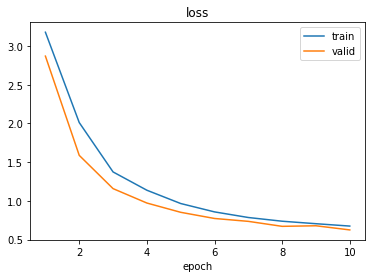

[Train] Epoch:11 loss:0.65554 loss1:0.22543 loss2:0.43011 acc:0.87739 prec:0.85717 rec:0.90587 f1:0.87803 
output([0.5577, 0.7264, 0.2704, 0.2692, 0.7230, 0.7123, 0.7245, 0.7245, 0.7274,
        0.2691, 0.7246, 0.2692, 0.2691, 0.7038, 0.3671, 0.7276, 0.7178, 0.7298,
        0.7267, 0.5378, 0.7197, 0.7256, 0.7245, 0.2695, 0.7297, 0.2690, 0.2692,
        0.7293, 0.7273, 0.5159, 0.2691, 0.2697, 0.2692, 0.7259, 0.2749, 0.2691,
        0.7273, 0.7266, 0.7281, 0.7090], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
        1., 1., 1., 1.], device='cuda:0')
[Valid] Epoch:11 loss:0.59864 loss1:0.19009 loss2:0.40855 acc:0.90938 prec:0.87537 rec:0.96037 f1:0.91369 
output([0.7289, 0.2743, 0.7284, 0.2705, 0.2726, 0.2724, 0.7288, 0.2700, 0.2700,
        0.2729, 0.4742, 0.7279, 0.6196, 0.7231, 0.7266, 0.7294, 0.2698, 0.7293,
        0.726

[Train] Epoch:17 loss:0.58603 loss1:0.16951 loss2:0.41652 acc:0.89301 prec:0.87063 rec:0.92587 f1:0.89474 
output([0.7306, 0.2699, 0.2698, 0.2709, 0.2690, 0.2706, 0.7304, 0.2708, 0.3569,
        0.7248, 0.2731, 0.7292, 0.7303, 0.2699, 0.7304, 0.2700, 0.7261, 0.7306,
        0.2697, 0.2696, 0.2696, 0.7302, 0.7304, 0.7301, 0.2699, 0.7259, 0.7309,
        0.2697, 0.2699, 0.7217, 0.7308, 0.7291, 0.7290, 0.2697, 0.7306, 0.7306,
        0.2701, 0.2700, 0.7299, 0.2702], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0.], device='cuda:0')
[Valid] Epoch:17 loss:0.56565 loss1:0.15082 loss2:0.41483 acc:0.89875 prec:0.85693 rec:0.94513 f1:0.89664 
output([0.7307, 0.7308, 0.2789, 0.2752, 0.2742, 0.7305, 0.4927, 0.2760, 0.7305,
        0.7304, 0.7299, 0.7309, 0.7243, 0.7310, 0.7308, 0.2813, 0.2721, 0.2731,
        0.730

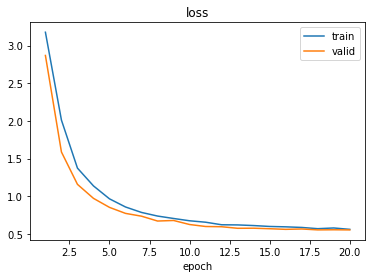

[Train] Epoch:21 loss:0.56295 loss1:0.15219 loss2:0.41076 acc:0.90110 prec:0.88437 rec:0.92661 f1:0.90208 
output([0.7306, 0.2691, 0.7303, 0.7305, 0.7305, 0.2692, 0.2690, 0.5609, 0.2690,
        0.7308, 0.2693, 0.2697, 0.7300, 0.7296, 0.7298, 0.7302, 0.2691, 0.7302,
        0.4842, 0.2690, 0.7307, 0.2691, 0.2691, 0.2691, 0.2693, 0.2693, 0.7088,
        0.7306, 0.7220, 0.6047, 0.7288, 0.2692, 0.7306, 0.7210, 0.7301, 0.7305,
        0.2697, 0.7307, 0.2691, 0.7301], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 1.], device='cuda:0')
[Valid] Epoch:21 loss:0.55376 loss1:0.14343 loss2:0.41033 acc:0.89750 prec:0.83276 rec:0.98872 f1:0.90173 
output([0.7283, 0.7297, 0.2694, 0.7298, 0.7302, 0.2693, 0.7277, 0.6734, 0.2818,
        0.5450, 0.3723, 0.7295, 0.7302, 0.2694, 0.7155, 0.7300, 0.2694, 0.7301,
        0.730

[Train] Epoch:27 loss:0.53847 loss1:0.14218 loss2:0.39629 acc:0.91452 prec:0.89597 rec:0.94254 f1:0.91602 
output([0.7308, 0.2691, 0.7298, 0.2697, 0.2690, 0.7306, 0.7303, 0.7305, 0.7307,
        0.2692, 0.2691, 0.7306, 0.2691, 0.7235, 0.7306, 0.2699, 0.2737, 0.7304,
        0.2692, 0.7307, 0.2695, 0.2690, 0.7302, 0.7307, 0.2692, 0.7307, 0.2690,
        0.7303, 0.7304, 0.2690, 0.2692, 0.7300, 0.2691, 0.2692, 0.7299, 0.2690,
        0.7304, 0.7297, 0.7308, 0.7308], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 1.], device='cuda:0')
[Valid] Epoch:27 loss:0.53868 loss1:0.13710 loss2:0.40158 acc:0.90750 prec:0.85678 rec:0.96952 f1:0.90810 
output([0.7306, 0.2854, 0.2691, 0.2697, 0.2692, 0.7303, 0.7303, 0.4768, 0.2691,
        0.7310, 0.7300, 0.2690, 0.2695, 0.7300, 0.2692, 0.7305, 0.2716, 0.2691,
        0.730

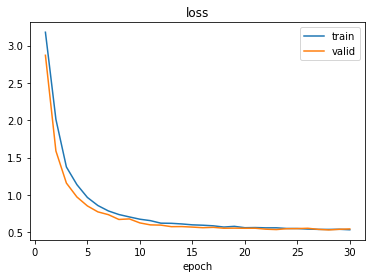

[Train] Epoch:31 loss:0.53081 loss1:0.13806 loss2:0.39274 acc:0.91599 prec:0.89757 rec:0.93920 f1:0.91540 
output([0.7309, 0.2695, 0.2691, 0.2694, 0.2696, 0.2792, 0.2701, 0.7310, 0.7311,
        0.7310, 0.7311, 0.2706, 0.7310, 0.2691, 0.7309, 0.2694, 0.7310, 0.2693,
        0.7309, 0.7310, 0.2694, 0.7310, 0.2692, 0.2696, 0.7262, 0.2702, 0.7310,
        0.2691, 0.2746, 0.7309, 0.2886, 0.4824, 0.2690, 0.2693, 0.3047, 0.2691,
        0.7310, 0.7310, 0.2939, 0.2705], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:31 loss:0.55406 loss1:0.13513 loss2:0.41893 acc:0.88938 prec:0.82093 rec:0.98440 f1:0.89328 
output([0.7306, 0.7304, 0.3459, 0.2708, 0.2702, 0.2708, 0.7299, 0.2702, 0.2698,
        0.2762, 0.2711, 0.7308, 0.7306, 0.2723, 0.7303, 0.2696, 0.2760, 0.7306,
        0.270

[Train] Epoch:37 loss:0.51565 loss1:0.13440 loss2:0.38125 acc:0.93070 prec:0.91345 rec:0.95178 f1:0.92992 
output([0.7310, 0.7308, 0.7310, 0.2691, 0.2690, 0.2692, 0.7302, 0.7310, 0.2693,
        0.2693, 0.2690, 0.7310, 0.7310, 0.7310, 0.2690, 0.7310, 0.7310, 0.2690,
        0.7309, 0.2692, 0.2692, 0.2690, 0.2690, 0.7310, 0.7306, 0.2691, 0.7309,
        0.2691, 0.7310, 0.2691, 0.2690, 0.7309, 0.2691, 0.2690, 0.2700, 0.7309,
        0.7301, 0.7310, 0.2693, 0.7297], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        1., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:37 loss:0.58699 loss1:0.13288 loss2:0.45411 acc:0.85500 prec:0.77570 rec:0.99881 f1:0.87108 
output([0.2691, 0.7310, 0.7309, 0.2695, 0.7310, 0.2692, 0.2691, 0.6509, 0.7310,
        0.7310, 0.7308, 0.7310, 0.7310, 0.2722, 0.2691, 0.7309, 0.7309, 0.2692,
        0.269

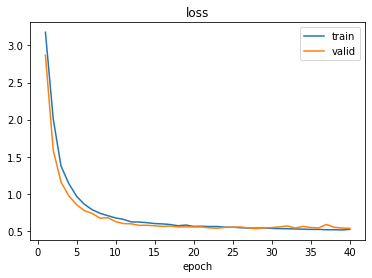

[Train] Epoch:41 loss:0.52262 loss1:0.13289 loss2:0.38972 acc:0.92022 prec:0.90723 rec:0.94019 f1:0.92092 
output([0.2691, 0.2690, 0.2692, 0.2689, 0.2697, 0.2691, 0.3212, 0.7310, 0.7308,
        0.7311, 0.2690, 0.3884, 0.7310, 0.7306, 0.2690, 0.7265, 0.2690, 0.2690,
        0.7310, 0.7295, 0.7306, 0.2690, 0.7308, 0.7307, 0.2690, 0.7310, 0.2690,
        0.7309, 0.2690, 0.2690, 0.7308, 0.7309, 0.7310, 0.7275, 0.7310, 0.2690,
        0.7301, 0.2690, 0.7311, 0.2693], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:41 loss:0.52899 loss1:0.13294 loss2:0.39605 acc:0.91437 prec:0.89474 rec:0.93947 f1:0.91547 
output([0.7311, 0.7306, 0.2702, 0.2693, 0.4317, 0.2693, 0.7310, 0.2694, 0.7309,
        0.7310, 0.2707, 0.7309, 0.2691, 0.2723, 0.7310, 0.7308, 0.7309, 0.7282,
        0.731

[Train] Epoch:47 loss:0.51406 loss1:0.13155 loss2:0.38251 acc:0.92849 prec:0.91170 rec:0.94821 f1:0.92745 
output([0.2692, 0.2690, 0.7310, 0.3024, 0.4519, 0.7310, 0.2690, 0.7311, 0.2691,
        0.7310, 0.2690, 0.7310, 0.2690, 0.2689, 0.2690, 0.7202, 0.7310, 0.2690,
        0.2690, 0.7310, 0.2690, 0.2694, 0.7309, 0.7310, 0.7310, 0.2913, 0.2690,
        0.4181, 0.7310, 0.2690, 0.7311, 0.7311, 0.7310, 0.2690, 0.2690, 0.2690,
        0.7310, 0.7306, 0.7310, 0.2691], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 1.], device='cuda:0')
[Valid] Epoch:47 loss:0.55412 loss1:0.13250 loss2:0.42162 acc:0.89062 prec:0.84162 rec:0.96973 f1:0.89903 
output([0.2690, 0.2690, 0.7310, 0.2691, 0.7310, 0.7302, 0.7310, 0.4768, 0.7310,
        0.7309, 0.7309, 0.2722, 0.7309, 0.7310, 0.2690, 0.2692, 0.7310, 0.2690,
        0.269

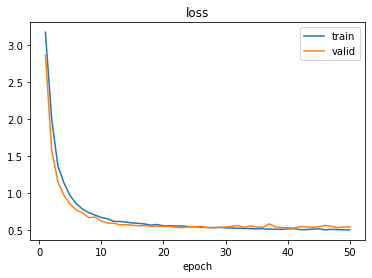

[Train] Epoch:51 loss:0.50265 loss1:0.13062 loss2:0.37203 acc:0.93952 prec:0.92009 rec:0.96384 f1:0.94036 
output([0.7309, 0.2739, 0.7310, 0.7310, 0.2748, 0.2689, 0.7309, 0.7310, 0.2707,
        0.7310, 0.7310, 0.2689, 0.2689, 0.2690, 0.7309, 0.2689, 0.7310, 0.7310,
        0.2689, 0.2689, 0.7310, 0.7299, 0.7310, 0.2690, 0.2689, 0.2690, 0.7309,
        0.2689, 0.7310, 0.2689, 0.7310, 0.7309, 0.7309, 0.7310, 0.2689, 0.7271,
        0.2689, 0.7310, 0.2690, 0.6817], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
        0., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:51 loss:0.54515 loss1:0.13166 loss2:0.41349 acc:0.89625 prec:0.87431 rec:0.92752 f1:0.89829 
output([0.2690, 0.7309, 0.2690, 0.7310, 0.7310, 0.2690, 0.2702, 0.7306, 0.7310,
        0.7310, 0.7310, 0.7310, 0.7310, 0.2691, 0.7309, 0.2690, 0.2690, 0.2690,
        0.269

[Train] Epoch:57 loss:0.50030 loss1:0.12952 loss2:0.37078 acc:0.94062 prec:0.92095 rec:0.96339 f1:0.94007 
output([0.7310, 0.2689, 0.7311, 0.2689, 0.7304, 0.7310, 0.7310, 0.2690, 0.7310,
        0.7310, 0.2689, 0.2690, 0.7310, 0.2689, 0.7214, 0.7278, 0.2689, 0.7129,
        0.2690, 0.7310, 0.2689, 0.7201, 0.7310, 0.7310, 0.7035, 0.7221, 0.7310,
        0.7296, 0.2689, 0.2689, 0.7310, 0.7310, 0.7309, 0.2689, 0.2689, 0.2690,
        0.7310, 0.2689, 0.7310, 0.2690], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:57 loss:0.53095 loss1:0.13040 loss2:0.40055 acc:0.91000 prec:0.87089 rec:0.96080 f1:0.91164 
output([0.7310, 0.7310, 0.7310, 0.2690, 0.2690, 0.5330, 0.2690, 0.2693, 0.2690,
        0.4980, 0.7310, 0.2690, 0.7309, 0.4319, 0.2691, 0.7310, 0.2890, 0.2696,
        0.516

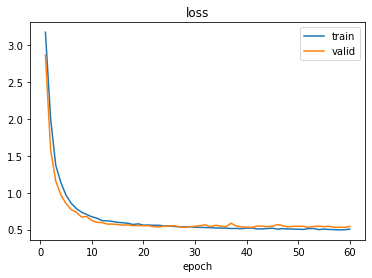

[Train] Epoch:61 loss:0.49504 loss1:0.12901 loss2:0.36603 acc:0.94522 prec:0.93190 rec:0.95977 f1:0.94434 
output([0.2691, 0.2691, 0.2705, 0.2689, 0.7310, 0.7310, 0.7311, 0.7311, 0.7311,
        0.2690, 0.2695, 0.2690, 0.2690, 0.2689, 0.2692, 0.7310, 0.2691, 0.7309,
        0.2691, 0.2691, 0.7310, 0.7311, 0.2692, 0.2690, 0.7311, 0.7311, 0.2690,
        0.2690, 0.7309, 0.7311, 0.2691, 0.2690, 0.7310, 0.2690, 0.7311, 0.2690,
        0.7310, 0.2690, 0.7311, 0.5465], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 0.], device='cuda:0')
[Valid] Epoch:61 loss:0.53515 loss1:0.13121 loss2:0.40394 acc:0.90062 prec:0.87898 rec:0.92223 f1:0.89765 
output([0.2731, 0.7310, 0.2689, 0.7310, 0.7311, 0.7310, 0.7310, 0.2694, 0.7307,
        0.7310, 0.2690, 0.2690, 0.7310, 0.7310, 0.7310, 0.2690, 0.4234, 0.7311,
        0.731

[Train] Epoch:67 loss:0.50274 loss1:0.12848 loss2:0.37426 acc:0.93603 prec:0.91452 rec:0.96217 f1:0.93613 
output([0.2690, 0.2693, 0.7311, 0.2691, 0.7311, 0.3467, 0.3317, 0.2699, 0.2696,
        0.2696, 0.2692, 0.3640, 0.2691, 0.7311, 0.2712, 0.7217, 0.2690, 0.2696,
        0.2691, 0.2690, 0.7311, 0.2695, 0.2703, 0.2692, 0.2692, 0.2741, 0.7311,
        0.2692, 0.7311, 0.2691, 0.2693, 0.7247, 0.2972, 0.7311, 0.7311, 0.2694,
        0.2690, 0.2693, 0.4536, 0.4614], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:67 loss:0.52518 loss1:0.13137 loss2:0.39381 acc:0.91750 prec:0.87770 rec:0.96872 f1:0.91962 
output([0.2690, 0.2690, 0.7311, 0.2689, 0.7310, 0.7015, 0.2690, 0.7311, 0.7310,
        0.7310, 0.2693, 0.2690, 0.7310, 0.7310, 0.2690, 0.7310, 0.7311, 0.7311,
        0.269

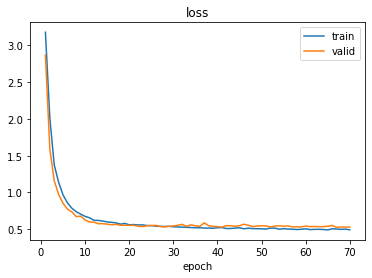

[Train] Epoch:71 loss:0.49104 loss1:0.12741 loss2:0.36362 acc:0.94816 prec:0.94029 rec:0.95947 f1:0.94858 
output([0.7310, 0.7309, 0.2693, 0.7310, 0.2690, 0.2689, 0.2698, 0.2689, 0.7310,
        0.7310, 0.7310, 0.7310, 0.2689, 0.2689, 0.2689, 0.2689, 0.7310, 0.7311,
        0.7310, 0.7310, 0.2689, 0.6705, 0.2781, 0.7311, 0.2690, 0.2689, 0.2689,
        0.2690, 0.7311, 0.7310, 0.7311, 0.7310, 0.7310, 0.2690, 0.2689, 0.3003,
        0.7311, 0.2690, 0.7310, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:71 loss:0.55140 loss1:0.13156 loss2:0.41984 acc:0.88688 prec:0.83656 rec:0.95444 f1:0.88893 
output([0.7311, 0.7310, 0.2690, 0.4431, 0.6606, 0.4315, 0.2689, 0.2786, 0.7310,
        0.7310, 0.2689, 0.2690, 0.2690, 0.7311, 0.2695, 0.2690, 0.7308, 0.7311,
        0.731

[Train] Epoch:77 loss:0.49024 loss1:0.12737 loss2:0.36287 acc:0.94908 prec:0.93484 rec:0.96542 f1:0.94870 
output([0.7311, 0.7310, 0.2689, 0.2690, 0.2690, 0.2689, 0.2689, 0.2690, 0.7310,
        0.2689, 0.2690, 0.7311, 0.2689, 0.7310, 0.2689, 0.2689, 0.7310, 0.6118,
        0.7310, 0.7310, 0.7311, 0.2690, 0.2689, 0.7308, 0.2689, 0.7311, 0.7311,
        0.7310, 0.2689, 0.7308, 0.2689, 0.7311, 0.2689, 0.2689, 0.7311, 0.7311,
        0.7310, 0.7309, 0.6847, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 1., 0.], device='cuda:0')
[Valid] Epoch:77 loss:0.54238 loss1:0.13094 loss2:0.41145 acc:0.89813 prec:0.87426 rec:0.93390 f1:0.90076 
output([0.2690, 0.2690, 0.2690, 0.2691, 0.2691, 0.6927, 0.7306, 0.2690, 0.7310,
        0.2690, 0.7288, 0.2690, 0.2690, 0.2690, 0.2690, 0.5983, 0.5621, 0.7310,
        0.269

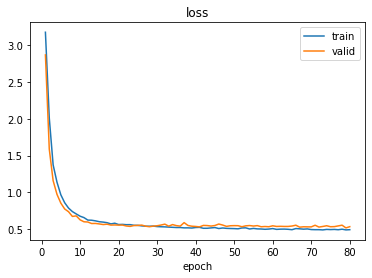

[Train] Epoch:81 loss:0.48541 loss1:0.12585 loss2:0.35956 acc:0.95184 prec:0.94092 rec:0.96602 f1:0.95218 
output([0.7308, 0.6400, 0.2689, 0.2690, 0.7311, 0.7310, 0.2689, 0.4439, 0.2689,
        0.2689, 0.7311, 0.7311, 0.2690, 0.4797, 0.7311, 0.7310, 0.2689, 0.2689,
        0.7311, 0.7310, 0.2689, 0.2690, 0.2689, 0.7311, 0.2690, 0.7311, 0.2690,
        0.7310, 0.7311, 0.7310, 0.2689, 0.7310, 0.7311, 0.7310, 0.2689, 0.2689,
        0.7254, 0.2689, 0.7311, 0.7311], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 1., 1.], device='cuda:0')
[Valid] Epoch:81 loss:0.54773 loss1:0.12882 loss2:0.41891 acc:0.89438 prec:0.83672 rec:0.96233 f1:0.89360 
output([0.7310, 0.2690, 0.7182, 0.2689, 0.2689, 0.7311, 0.7311, 0.7310, 0.7311,
        0.7310, 0.2690, 0.2690, 0.7311, 0.7311, 0.7261, 0.2690, 0.2690, 0.7311,
        0.269

[Train] Epoch:87 loss:0.49365 loss1:0.12609 loss2:0.36757 acc:0.94449 prec:0.92849 rec:0.96458 f1:0.94428 
output([0.7311, 0.2689, 0.7310, 0.7311, 0.2689, 0.7310, 0.2689, 0.7311, 0.7269,
        0.2689, 0.7311, 0.2689, 0.2689, 0.7311, 0.2690, 0.2690, 0.2689, 0.2690,
        0.2689, 0.2690, 0.7310, 0.7311, 0.2690, 0.7309, 0.7307, 0.7311, 0.2689,
        0.7311, 0.7310, 0.2689, 0.7310, 0.2689, 0.7311, 0.7311, 0.2691, 0.2689,
        0.2690, 0.2689, 0.7311, 0.7311], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 1., 1.], device='cuda:0')
[Valid] Epoch:87 loss:0.52510 loss1:0.12866 loss2:0.39644 acc:0.91500 prec:0.89884 rec:0.92908 f1:0.91214 
output([0.7310, 0.2690, 0.2689, 0.7304, 0.2689, 0.7310, 0.7310, 0.7310, 0.2690,
        0.2690, 0.2691, 0.2690, 0.7311, 0.7311, 0.7311, 0.7310, 0.7310, 0.2690,
        0.269

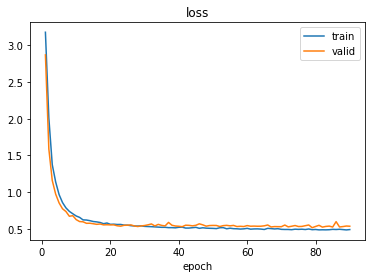

[Train] Epoch:91 loss:0.48650 loss1:0.12555 loss2:0.36095 acc:0.95073 prec:0.93950 rec:0.96383 f1:0.95051 
output([0.2689, 0.7310, 0.7310, 0.2689, 0.2689, 0.7311, 0.2690, 0.7310, 0.2689,
        0.7311, 0.2689, 0.7311, 0.2690, 0.7310, 0.2689, 0.5385, 0.7299, 0.7310,
        0.2689, 0.2689, 0.2689, 0.2689, 0.4911, 0.7311, 0.7311, 0.2689, 0.7310,
        0.7311, 0.2689, 0.2689, 0.7310, 0.7310, 0.7310, 0.7311, 0.7310, 0.7311,
        0.2689, 0.2690, 0.7311, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:91 loss:0.53451 loss1:0.13113 loss2:0.40338 acc:0.90250 prec:0.90603 rec:0.89766 f1:0.89972 
output([0.7311, 0.6569, 0.7310, 0.7311, 0.2690, 0.2689, 0.2689, 0.7310, 0.7311,
        0.2689, 0.2690, 0.3132, 0.7311, 0.7311, 0.2689, 0.7310, 0.7311, 0.2690,
        0.731

[Train] Epoch:97 loss:0.48531 loss1:0.12540 loss2:0.35991 acc:0.95257 prec:0.94306 rec:0.96435 f1:0.95207 
output([0.2689, 0.7309, 0.2689, 0.7310, 0.7310, 0.2689, 0.7310, 0.7310, 0.2689,
        0.2689, 0.7311, 0.7310, 0.7310, 0.2689, 0.7311, 0.7311, 0.2689, 0.7309,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311, 0.7310, 0.7311, 0.7310,
        0.7311, 0.7310, 0.2689, 0.7310, 0.7310, 0.7310, 0.2689, 0.2689, 0.7311,
        0.2713, 0.7310, 0.2690, 0.7310], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 1.], device='cuda:0')
[Valid] Epoch:97 loss:0.53677 loss1:0.13080 loss2:0.40597 acc:0.90688 prec:0.91142 rec:0.90814 f1:0.90813 
output([0.7311, 0.2690, 0.7310, 0.2689, 0.7149, 0.4283, 0.7311, 0.7310, 0.7309,
        0.2689, 0.2690, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311,
        0.268

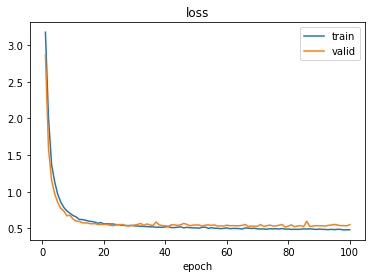

[Train] Epoch:101 loss:0.48143 loss1:0.12466 loss2:0.35677 acc:0.95404 prec:0.94923 rec:0.95836 f1:0.95256 
output([0.2689, 0.7311, 0.2690, 0.2689, 0.7311, 0.7310, 0.7311, 0.2689, 0.4464,
        0.2689, 0.2689, 0.7311, 0.2689, 0.7311, 0.7311, 0.2689, 0.7311, 0.7310,
        0.2689, 0.2689, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.2690,
        0.2689, 0.2689, 0.2689, 0.7311, 0.2689, 0.2690, 0.7311, 0.2691, 0.2689,
        0.7310, 0.6646, 0.2689, 0.2694], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:101 loss:0.53171 loss1:0.12878 loss2:0.40292 acc:0.90625 prec:0.90108 rec:0.91305 f1:0.90551 
output([0.2689, 0.7311, 0.2689, 0.7131, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689,
        0.7310, 0.7310, 0.2691, 0.7311, 0.7311, 0.7310, 0.7311, 0.2689, 0.2690,
        0.2

[Train] Epoch:107 loss:0.49195 loss1:0.12871 loss2:0.36324 acc:0.94779 prec:0.93886 rec:0.95903 f1:0.94736 
output([0.7310, 0.6512, 0.7311, 0.2689, 0.7309, 0.6312, 0.7296, 0.7310, 0.7310,
        0.7310, 0.7311, 0.2690, 0.2689, 0.2689, 0.7310, 0.7310, 0.7311, 0.7309,
        0.7310, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7310, 0.7310, 0.7311,
        0.2689, 0.7310, 0.7311, 0.2689, 0.2689, 0.2689, 0.2689, 0.7310, 0.7311,
        0.2689, 0.2689, 0.7310, 0.7310], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 1.], device='cuda:0')
[Valid] Epoch:107 loss:0.54845 loss1:0.13613 loss2:0.41232 acc:0.89813 prec:0.91284 rec:0.88311 f1:0.89539 
output([0.2689, 0.2691, 0.2689, 0.7311, 0.7310, 0.7311, 0.2689, 0.7311, 0.7311,
        0.7311, 0.7309, 0.4523, 0.7310, 0.2689, 0.7310, 0.7311, 0.2689, 0.7310,
        0.2

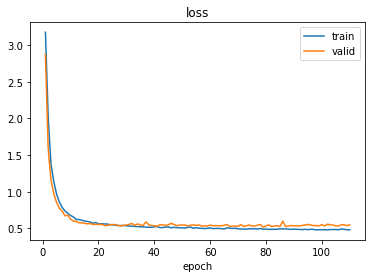

[Train] Epoch:111 loss:0.47563 loss1:0.12403 loss2:0.35160 acc:0.96066 prec:0.94906 rec:0.97580 f1:0.96141 
output([0.7310, 0.2689, 0.7311, 0.7310, 0.7311, 0.2689, 0.2689, 0.7311, 0.7311,
        0.7310, 0.7311, 0.7311, 0.7311, 0.2689, 0.2689, 0.2689, 0.7311, 0.7310,
        0.2689, 0.2689, 0.2689, 0.7130, 0.2689, 0.2689, 0.7311, 0.7213, 0.2689,
        0.2689, 0.7310, 0.7311, 0.2689, 0.7311, 0.7311, 0.2750, 0.2690, 0.7310,
        0.2689, 0.7310, 0.2689, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        0., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:111 loss:0.53584 loss1:0.13150 loss2:0.40434 acc:0.90500 prec:0.92487 rec:0.87775 f1:0.89846 
output([0.7310, 0.2689, 0.2689, 0.7310, 0.7310, 0.7310, 0.7310, 0.2689, 0.2689,
        0.2689, 0.2689, 0.2689, 0.2689, 0.7310, 0.7311, 0.2689, 0.2690, 0.2689,
        0.7

[Train] Epoch:117 loss:0.47545 loss1:0.12315 loss2:0.35230 acc:0.96066 prec:0.94855 rec:0.97389 f1:0.95992 
output([0.2689, 0.7302, 0.7281, 0.7306, 0.7310, 0.7311, 0.7309, 0.7311, 0.7310,
        0.7310, 0.2689, 0.2689, 0.7311, 0.7305, 0.7310, 0.2689, 0.7308, 0.7305,
        0.7310, 0.7311, 0.6163, 0.7310, 0.7302, 0.7309, 0.2689, 0.7285, 0.7303,
        0.7307, 0.2689, 0.2689, 0.7311, 0.2689, 0.7307, 0.2689, 0.7310, 0.2689,
        0.2689, 0.2689, 0.7310, 0.7304], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 1.], device='cuda:0')
[Valid] Epoch:117 loss:0.53431 loss1:0.12919 loss2:0.40511 acc:0.90562 prec:0.90653 rec:0.89936 f1:0.90080 
output([0.7311, 0.7311, 0.2691, 0.7311, 0.2690, 0.7311, 0.7311, 0.7310, 0.2690,
        0.3817, 0.2690, 0.7311, 0.7310, 0.2689, 0.2689, 0.7305, 0.2690, 0.2689,
        0.2

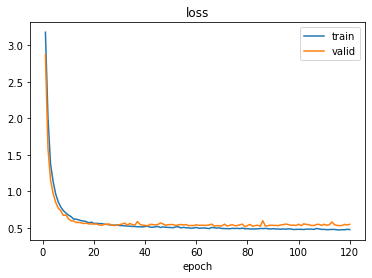

[Train] Epoch:121 loss:0.47522 loss1:0.12238 loss2:0.35283 acc:0.95846 prec:0.95231 rec:0.96688 f1:0.95853 
output([0.7311, 0.7310, 0.7310, 0.7310, 0.2689, 0.2689, 0.2689, 0.2689, 0.7310,
        0.7310, 0.7310, 0.7310, 0.7309, 0.2689, 0.2689, 0.7310, 0.7310, 0.2689,
        0.2689, 0.2689, 0.7301, 0.7310, 0.7311, 0.7311, 0.7311, 0.7310, 0.7310,
        0.7311, 0.2689, 0.2689, 0.7311, 0.7311, 0.2689, 0.7311, 0.7310, 0.2690,
        0.2689, 0.7310, 0.2689, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:121 loss:0.54436 loss1:0.12858 loss2:0.41578 acc:0.89188 prec:0.90168 rec:0.86560 f1:0.88067 
output([0.7311, 0.2689, 0.2689, 0.2689, 0.7311, 0.6825, 0.2689, 0.2689, 0.2689,
        0.7311, 0.7311, 0.2690, 0.7072, 0.7310, 0.7311, 0.2689, 0.2689, 0.2689,
        0.2

[Train] Epoch:127 loss:0.48173 loss1:0.12261 loss2:0.35912 acc:0.95221 prec:0.93882 rec:0.96514 f1:0.95016 
output([0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7310, 0.2689, 0.7311,
        0.7311, 0.7310, 0.7311, 0.7311, 0.7310, 0.7311, 0.2689, 0.7310, 0.7311,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311, 0.2689,
        0.7311, 0.2689, 0.7311, 0.7311, 0.2689, 0.7311, 0.7251, 0.7311, 0.2689,
        0.7311, 0.2689, 0.7310, 0.7311], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 1., 1.], device='cuda:0')
[Valid] Epoch:127 loss:0.55700 loss1:0.13003 loss2:0.42697 acc:0.88375 prec:0.88976 rec:0.87073 f1:0.87797 
output([0.7311, 0.7311, 0.7311, 0.7310, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689,
        0.2689, 0.7311, 0.2689, 0.2690, 0.2690, 0.7311, 0.2694, 0.2689, 0.7310,
        0.2

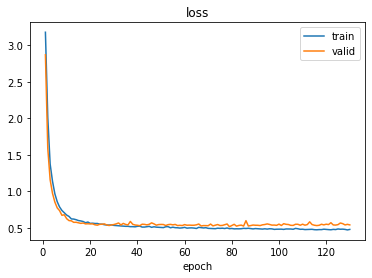

[Train] Epoch:131 loss:0.47271 loss1:0.12190 loss2:0.35080 acc:0.96232 prec:0.94983 rec:0.97573 f1:0.96168 
output([0.7311, 0.2689, 0.2689, 0.2689, 0.7311, 0.7311, 0.2689, 0.2689, 0.7311,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.2689, 0.7311, 0.7311, 0.7311, 0.2689, 0.2689, 0.7311,
        0.5065, 0.2689, 0.7311, 0.2689, 0.2689, 0.6627, 0.7311, 0.7311, 0.2689,
        0.7310, 0.7311, 0.7310, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 0.], device='cuda:0')
[Valid] Epoch:131 loss:0.54516 loss1:0.13611 loss2:0.40905 acc:0.90000 prec:0.88241 rec:0.91703 f1:0.89724 
output([0.2694, 0.2689, 0.7310, 0.2689, 0.7311, 0.2805, 0.2689, 0.2689, 0.2689,
        0.7307, 0.7311, 0.2690, 0.2689, 0.2689, 0.7311, 0.7309, 0.7311, 0.7311,
        0.2

[Train] Epoch:137 loss:0.47575 loss1:0.12183 loss2:0.35391 acc:0.95827 prec:0.95378 rec:0.96384 f1:0.95765 
output([0.2689, 0.2690, 0.7311, 0.7311, 0.2690, 0.7311, 0.7311, 0.7311, 0.2689,
        0.7311, 0.7311, 0.7311, 0.2689, 0.2689, 0.2690, 0.2690, 0.2690, 0.2689,
        0.7311, 0.2689, 0.2689, 0.7311, 0.7311, 0.2689, 0.7310, 0.7311, 0.7311,
        0.2689, 0.7311, 0.7303, 0.2689, 0.2690, 0.2689, 0.2689, 0.2690, 0.2690,
        0.7311, 0.7310, 0.2689, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:137 loss:0.53494 loss1:0.12917 loss2:0.40577 acc:0.90375 prec:0.92254 rec:0.87638 f1:0.89671 
output([0.2689, 0.2689, 0.2689, 0.2689, 0.7236, 0.2690, 0.7308, 0.2690, 0.7311,
        0.7310, 0.2689, 0.7311, 0.7161, 0.7311, 0.7310, 0.7311, 0.2689, 0.7311,
        0.2

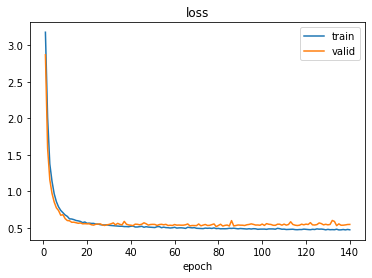

[Train] Epoch:141 loss:0.47744 loss1:0.12199 loss2:0.35546 acc:0.95754 prec:0.94757 rec:0.97063 f1:0.95799 
output([0.2689, 0.2690, 0.7311, 0.2689, 0.7311, 0.2689, 0.7307, 0.7311, 0.7309,
        0.2689, 0.2689, 0.6724, 0.2689, 0.2690, 0.2690, 0.2690, 0.2689, 0.2690,
        0.7311, 0.7311, 0.2689, 0.7311, 0.2690, 0.2689, 0.2689, 0.7311, 0.7311,
        0.6665, 0.7307, 0.2689, 0.2689, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.2689, 0.2689, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 0.], device='cuda:0')
[Valid] Epoch:141 loss:0.54416 loss1:0.13100 loss2:0.41315 acc:0.89625 prec:0.92011 rec:0.85870 f1:0.88451 
output([0.7310, 0.2689, 0.7311, 0.2690, 0.2690, 0.7310, 0.7310, 0.7310, 0.2690,
        0.7311, 0.2689, 0.2689, 0.7310, 0.7311, 0.7311, 0.7311, 0.2689, 0.7311,
        0.2

[Train] Epoch:147 loss:0.46778 loss1:0.12094 loss2:0.34684 acc:0.96581 prec:0.95662 rec:0.97659 f1:0.96558 
output([0.2690, 0.2690, 0.7311, 0.2690, 0.2689, 0.2692, 0.2689, 0.2690, 0.7311,
        0.7311, 0.6776, 0.2690, 0.7309, 0.2690, 0.7311, 0.7311, 0.2689, 0.7311,
        0.2690, 0.7311, 0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.2689, 0.7311,
        0.2690, 0.2689, 0.7311, 0.7311, 0.7311, 0.7311, 0.2690, 0.2690, 0.2690,
        0.2690, 0.2689, 0.2689, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
[Valid] Epoch:147 loss:0.56226 loss1:0.13041 loss2:0.43185 acc:0.87938 prec:0.89894 rec:0.83710 f1:0.86544 
output([0.7311, 0.7311, 0.2690, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2690,
        0.2689, 0.7311, 0.2692, 0.7311, 0.7311, 0.7311, 0.2689, 0.7311, 0.7311,
        0.7

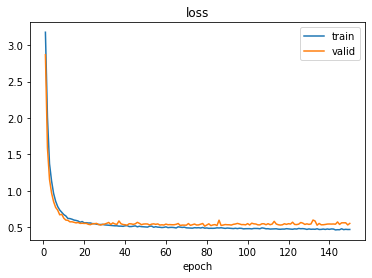

[Train] Epoch:151 loss:0.47119 loss1:0.11987 loss2:0.35132 acc:0.96103 prec:0.95187 rec:0.97177 f1:0.96060 
output([0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7311, 0.7311, 0.2689, 0.2689, 0.2689, 0.7310, 0.2711, 0.7311,
        0.2689, 0.2690, 0.2689, 0.7310, 0.7311, 0.7310, 0.2689, 0.2689, 0.2689,
        0.2689, 0.7311, 0.2689, 0.7311, 0.2690, 0.7310, 0.7311, 0.2689, 0.2689,
        0.7311, 0.2689, 0.7311, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:151 loss:0.56575 loss1:0.13464 loss2:0.43111 acc:0.87813 prec:0.91806 rec:0.83579 f1:0.87255 
output([0.2689, 0.7311, 0.2689, 0.2689, 0.2689, 0.2690, 0.7309, 0.7311, 0.7310,
        0.7263, 0.2689, 0.2689, 0.2689, 0.2689, 0.7310, 0.2689, 0.2693, 0.7311,
        0.7

[Train] Epoch:157 loss:0.47078 loss1:0.12044 loss2:0.35035 acc:0.96268 prec:0.95976 rec:0.96787 f1:0.96282 
output([0.2689, 0.2689, 0.2689, 0.2689, 0.7309, 0.7311, 0.7310, 0.7310, 0.7310,
        0.7311, 0.7311, 0.7310, 0.7311, 0.2689, 0.2689, 0.2691, 0.2689, 0.2689,
        0.7311, 0.7310, 0.2689, 0.2689, 0.2689, 0.7311, 0.7311, 0.2689, 0.7311,
        0.2689, 0.2689, 0.2689, 0.7310, 0.7311, 0.7311, 0.2689, 0.2690, 0.2689,
        0.7311, 0.2689, 0.7310, 0.7311], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 1.], device='cuda:0')
[Valid] Epoch:157 loss:0.54512 loss1:0.12885 loss2:0.41626 acc:0.89187 prec:0.92686 rec:0.86524 f1:0.89234 
output([0.2690, 0.5266, 0.7310, 0.4363, 0.7310, 0.7311, 0.7311, 0.7310, 0.2689,
        0.7310, 0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.2690, 0.2689, 0.7310,
        0.2

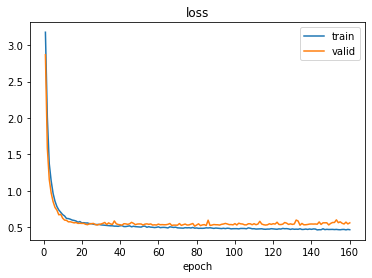

[Train] Epoch:161 loss:0.45971 loss1:0.11882 loss2:0.34088 acc:0.97206 prec:0.96413 rec:0.97922 f1:0.97092 
output([0.7311, 0.7311, 0.2689, 0.2689, 0.7310, 0.7311, 0.7310, 0.2689, 0.2689,
        0.2690, 0.7310, 0.7311, 0.2689, 0.7311, 0.2689, 0.7311, 0.2690, 0.7311,
        0.2689, 0.7309, 0.7310, 0.2689, 0.2689, 0.7311, 0.7311, 0.7311, 0.7310,
        0.2689, 0.7311, 0.2689, 0.2690, 0.2689, 0.7311, 0.7310, 0.2689, 0.7311,
        0.2689, 0.7311, 0.2689, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0.], device='cuda:0')
[Valid] Epoch:161 loss:0.55724 loss1:0.13451 loss2:0.42272 acc:0.88688 prec:0.94178 rec:0.81523 f1:0.87056 
output([0.2690, 0.2689, 0.2689, 0.7311, 0.7311, 0.2690, 0.2689, 0.2689, 0.2689,
        0.7311, 0.2689, 0.2689, 0.2689, 0.7310, 0.2689, 0.2689, 0.2690, 0.5040,
        0.2

[Train] Epoch:167 loss:0.46620 loss1:0.11874 loss2:0.34746 acc:0.96452 prec:0.95708 rec:0.97242 f1:0.96377 
output([0.2690, 0.7311, 0.7311, 0.2690, 0.2690, 0.2690, 0.2690, 0.2690, 0.2690,
        0.2690, 0.2690, 0.2690, 0.7311, 0.2690, 0.2690, 0.7311, 0.7311, 0.7311,
        0.2690, 0.2690, 0.2690, 0.2690, 0.2690, 0.2690, 0.7311, 0.7311, 0.7311,
        0.2690, 0.2690, 0.7311, 0.2689, 0.7311, 0.2690, 0.2690, 0.2689, 0.7311,
        0.2690, 0.2690, 0.7311, 0.2741], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:167 loss:0.55235 loss1:0.13240 loss2:0.41995 acc:0.89125 prec:0.91062 rec:0.85487 f1:0.87964 
output([0.2689, 0.2689, 0.2690, 0.2689, 0.7311, 0.2689, 0.2690, 0.7311, 0.7311,
        0.7311, 0.2689, 0.7311, 0.7311, 0.2690, 0.7311, 0.7311, 0.7311, 0.2689,
        0.2

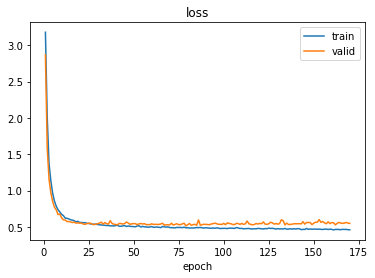

[Train] Epoch:171 loss:0.46360 loss1:0.11793 loss2:0.34567 acc:0.96673 prec:0.96350 rec:0.97132 f1:0.96655 
output([0.7311, 0.2689, 0.2690, 0.7311, 0.2689, 0.7311, 0.2689, 0.7311, 0.7311,
        0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689, 0.7311, 0.7311,
        0.2689, 0.2689, 0.2689, 0.2689, 0.2690, 0.2689, 0.7311, 0.2721, 0.7311,
        0.2689, 0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.7311, 0.7311, 0.2689,
        0.2689, 0.7311, 0.2689, 0.7311], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 1.], device='cuda:0')
[Valid] Epoch:171 loss:0.57116 loss1:0.13725 loss2:0.43391 acc:0.87375 prec:0.90473 rec:0.84428 f1:0.87124 
output([0.2689, 0.2689, 0.7311, 0.7311, 0.7311, 0.2689, 0.7310, 0.7311, 0.7311,
        0.2689, 0.2689, 0.7311, 0.2689, 0.7311, 0.4348, 0.2689, 0.2713, 0.2689,
        0.2

[Train] Epoch:177 loss:0.46259 loss1:0.11728 loss2:0.34531 acc:0.96691 prec:0.96095 rec:0.97559 f1:0.96744 
output([0.7311, 0.2690, 0.2690, 0.2689, 0.7311, 0.7311, 0.7311, 0.2690, 0.7311,
        0.2690, 0.2702, 0.2690, 0.2691, 0.2689, 0.2690, 0.7311, 0.2690, 0.2690,
        0.2690, 0.2690, 0.2691, 0.2690, 0.7311, 0.7311, 0.2690, 0.7311, 0.2689,
        0.7311, 0.2690, 0.2690, 0.2689, 0.7311, 0.2690, 0.2690, 0.7311, 0.2689,
        0.2689, 0.7311, 0.7311, 0.7311], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1.], device='cuda:0')
[Valid] Epoch:177 loss:0.56338 loss1:0.13609 loss2:0.42730 acc:0.87812 prec:0.92231 rec:0.81627 f1:0.86226 
output([0.7311, 0.2709, 0.2689, 0.7311, 0.4545, 0.7311, 0.3375, 0.2690, 0.2690,
        0.2691, 0.2689, 0.7307, 0.7232, 0.2689, 0.7311, 0.2690, 0.2690, 0.4470,
        0.2

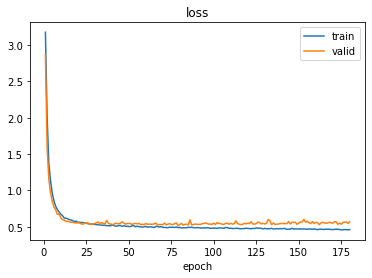

[Train] Epoch:181 loss:0.46612 loss1:0.11767 loss2:0.34845 acc:0.96342 prec:0.95537 rec:0.97549 f1:0.96457 
output([0.7311, 0.7311, 0.7311, 0.2689, 0.7311, 0.7311, 0.7310, 0.2689, 0.7311,
        0.2689, 0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.2689, 0.7311, 0.2691,
        0.7311, 0.2689, 0.7311, 0.7311, 0.2689, 0.2689, 0.7311, 0.2689, 0.2689,
        0.7311, 0.7311, 0.7311, 0.6177, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311,
        0.7311, 0.2689, 0.7311, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 0.], device='cuda:0')
[Valid] Epoch:181 loss:0.57188 loss1:0.13400 loss2:0.43788 acc:0.87125 prec:0.91069 rec:0.83665 f1:0.86878 
output([0.2689, 0.2703, 0.7311, 0.2960, 0.2689, 0.4587, 0.2691, 0.7311, 0.2690,
        0.2690, 0.2696, 0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.7311, 0.2690,
        0.7

[Train] Epoch:187 loss:0.45647 loss1:0.11526 loss2:0.34122 acc:0.97243 prec:0.96788 rec:0.97780 f1:0.97195 
output([0.7311, 0.2689, 0.7311, 0.2690, 0.7311, 0.2692, 0.7311, 0.2689, 0.7311,
        0.2689, 0.2734, 0.7311, 0.2689, 0.7311, 0.2689, 0.7311, 0.7311, 0.2689,
        0.7311, 0.2689, 0.2689, 0.2689, 0.2690, 0.2690, 0.2689, 0.7311, 0.2690,
        0.2689, 0.7311, 0.2689, 0.7311, 0.2689, 0.2689, 0.2689, 0.7311, 0.7311,
        0.7311, 0.2690, 0.2691, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0.], device='cuda:0')
[Valid] Epoch:187 loss:0.56255 loss1:0.13100 loss2:0.43156 acc:0.87937 prec:0.89945 rec:0.84564 f1:0.86899 
output([0.2689, 0.7311, 0.7311, 0.2689, 0.2689, 0.2689, 0.7311, 0.7311, 0.7311,
        0.2689, 0.7311, 0.2689, 0.2689, 0.7311, 0.7311, 0.7311, 0.2689, 0.7311,
        0.7

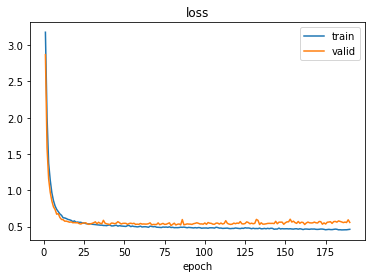

[Train] Epoch:191 loss:0.46229 loss1:0.11627 loss2:0.34603 acc:0.96618 prec:0.96173 rec:0.97336 f1:0.96686 
output([0.2689, 0.7311, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.7311,
        0.2689, 0.2689, 0.7311, 0.7311, 0.2689, 0.7311, 0.7311, 0.7311, 0.7311,
        0.2689, 0.2689, 0.2689, 0.2689, 0.7311, 0.7311, 0.7311, 0.7311, 0.2689,
        0.2689, 0.7311, 0.7311, 0.7311, 0.7311, 0.2689, 0.2689, 0.7311, 0.7311,
        0.7311, 0.2689, 0.2689, 0.7311], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 1.], device='cuda:0')
[Valid] Epoch:191 loss:0.54311 loss1:0.13299 loss2:0.41012 acc:0.90312 prec:0.92400 rec:0.86904 f1:0.89261 
output([0.7311, 0.2689, 0.7310, 0.7311, 0.7310, 0.7310, 0.2693, 0.7310, 0.7306,
        0.7291, 0.7309, 0.7311, 0.7311, 0.7311, 0.2689, 0.4571, 0.2689, 0.7311,
        0.2

[Train] Epoch:197 loss:0.45404 loss1:0.11470 loss2:0.33934 acc:0.97243 prec:0.96974 rec:0.97680 f1:0.97257 
output([0.7311, 0.2689, 0.2689, 0.7311, 0.7311, 0.2689, 0.2689, 0.7311, 0.2689,
        0.2689, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.2689, 0.2689,
        0.2689, 0.2690, 0.2689, 0.7311, 0.7311, 0.2689, 0.2689, 0.2690, 0.2689,
        0.2689, 0.7311, 0.7311, 0.2689, 0.6456, 0.7311, 0.7311, 0.2689, 0.7311,
        0.2690, 0.2691, 0.2689, 0.2689], device='cuda:0',
       grad_fn=<SelectBackward>)
labels([1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0.], device='cuda:0')
[Valid] Epoch:197 loss:0.56993 loss1:0.13741 loss2:0.43252 acc:0.87938 prec:0.91804 rec:0.83614 f1:0.87262 
output([0.7295, 0.4350, 0.7311, 0.7310, 0.2689, 0.7310, 0.4715, 0.7311, 0.2692,
        0.7310, 0.2690, 0.7311, 0.7311, 0.7071, 0.2689, 0.7311, 0.2689, 0.2689,
        0.2

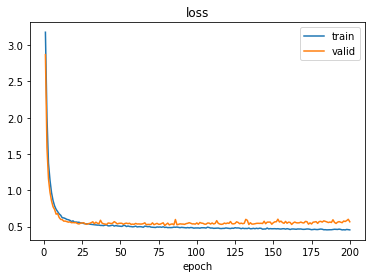

The best epoch of valid loss : Epoch:{} 79


NameError: name 'history' is not defined

In [9]:
# dataset
train_dataset, valid_dataset = Dataset(train_files, train_labels), Dataset(valid_files, valid_labels)
# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = MINI_BATCH, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = MINI_BATCH, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
# history lists for metrics
train_history = {'loss':[], 'loss1':[] ,'loss2':[], 'acc':[], 'prec':[], 'rec':[], 'f1':[]}
valid_history = {'loss':[], 'loss1':[] ,'loss2':[], 'acc':[], 'prec':[], 'rec':[], 'f1':[]}

# for faster
torch.backends.cudnn.benchmark = True
# model
net = Net().to(device)
# optimizer
optimizer = torch.optim.Adam(params = net.parameters(), lr = 0.0001)
# loss function
loss_function1, loss_function2 = torch.nn.L1Loss(), torch.nn.BCELoss()

for epoch in range(EPOCH):
    # output_label for csv
    train_output = {'output':np.array([]), 'label':np.array([])}
    valid_output = {'output':np.array([]), 'label':np.array([])}

    train_valid('train', net, device, train_loader, loss_function1, loss_function2, optimizer, train_output, train_history, train_writer)
    train_valid('valid', net, device, valid_loader, loss_function1, loss_function2, None, valid_output, valid_history, valid_writer)
    
    print('\n=====================\n')
    
    output_csv(train_output, epoch, 'train')
    output_csv(valid_output, epoch, 'valid')
    

    if min(valid_history['loss']) == valid_history['loss'][-1]:
        torch.save(net.state_dict(), SAVE_DIR+'_model_best.pth')
        
    # plot and save graph
    if (epoch+1)%10 == 0:
        plotGraph(train_history['loss'], valid_history['loss'], epoch, 'loss')

train_writer.close()
valid_writer.close()

best_epoch = valid_history['loss'].index(min(valid_history['loss']))+1
print('The best epoch of valid loss : Epoch:{}', best_epoch)
print('[Train] ' + history(train_history, best_epoch))
print('[Valid] ' + history(valid_history, best_epoch))